<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/simpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 마운트 시키기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/밑시딥2/DLFromScratch2

/content/drive/MyDrive/밑시딥2/DLFromScratch2


# RNN 계층 만들기

In [ ]:
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.t)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.t)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

# Time RNN 계층 구현

In [ ]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    
    self.h, self.dh = None, None
    self.statefull = stateful

  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    dxs = np.empty((N, T, D), dype='f')
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx

      for i, grad in enumerate(layer.grads):
        grads[i] += grads

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs

In [ ]:
!cd /content/drive/MyDrive/밑시딥2/DLFromScratch2/common
!cd /content/drive/MyDrive/밑시딥2/DLFromScratch2
!dir

cbow_params.pkl						Chap07-Seq2Seq
Chap01-Neural_Networks_Review				Chap08-Attention
Chap02-Natural_Language_and_Distributed_Representation	common
Chap03-Word2Vec						cover.jpg
Chap04_Word2Vec_Improved				dataset
Chap05-Recurrent_Neural_Network				equations_and_figures_2
Chap06-Fancy_RNN					README.md


# simpleRNNlm (language model)

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H  = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, D) / np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    # 모든 가중치와 기울기를 리스트에 모은다
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
  def backward(self, dout=1):
      dout = self.loss_layer.backward(dout)
      for layer in reversed(self.layers):
          dout = layer.backward(dout)
      return dout
  
  def reset_state(self):
      self.rnn_layer.reset_state()

# 학습 시키기

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 379.01
| 에폭 2 | 퍼플렉서티 248.61
| 에폭 3 | 퍼플렉서티 221.04
| 에폭 4 | 퍼플렉서티 212.62
| 에폭 5 | 퍼플렉서티 205.01
| 에폭 6 | 퍼플렉서티 201.74
| 에폭 7 | 퍼플렉서티 197.77
| 에폭 8 | 퍼플렉서티 195.74
| 에폭 9 | 퍼플렉서티 192.07
| 에폭 10 | 퍼플렉서티 192.71
| 에폭 11 | 퍼플렉서티 188.67
| 에폭 12 | 퍼플렉서티 192.53
| 에폭 13 | 퍼플렉서티 190.08
| 에폭 14 | 퍼플렉서티 190.97
| 에폭 15 | 퍼플렉서티 191.21
| 에폭 16 | 퍼플렉서티 186.90
| 에폭 17 | 퍼플렉서티 184.37
| 에폭 18 | 퍼플렉서티 182.08
| 에폭 19 | 퍼플렉서티 183.13
| 에폭 20 | 퍼플렉서티 185.16
| 에폭 21 | 퍼플렉서티 182.37
| 에폭 22 | 퍼플렉서티 178.76
| 에폭 23 | 퍼플렉서티 175.23
| 에폭 24 | 퍼플렉서티 177.29
| 에폭 25 | 퍼플렉서티 175.29
| 에폭 26 | 퍼플렉서티 174.23
| 에폭 27 | 퍼플렉서티 169.08
| 에폭 28 | 퍼플렉서티 167.33
| 에폭 29 | 퍼플렉서티 164.15
| 에폭 30 | 퍼플렉서티 161.06
| 에폭 31 | 퍼플렉서티 160.68
| 에폭 32 | 퍼플렉서티 156.34
| 에폭 33 | 퍼플렉서티 155.23
| 에폭 34 | 퍼플렉서티 149.99
| 에폭 35 | 퍼플렉서티 148.82
| 에폭 36 | 퍼플렉서티 143.05
| 에폭 37 | 퍼플렉서티 138.31
| 에폭 38 | 퍼플렉서티 135.69
| 에폭 39 | 퍼플렉서티 128.59
| 에폭 40 | 퍼플렉서티 124.76
| 에폭 41 | 퍼플렉서티 122.62
| 에폭 42 | 퍼플렉서티 117.45
| 에폭 43 | 퍼플렉서티 112

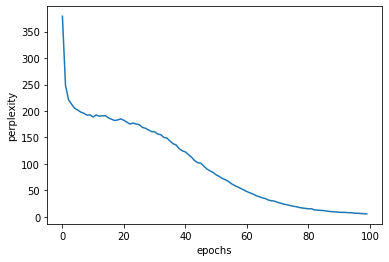

In [ ]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()